In [1]:
import json
import os
import pandas as pd
from plotnine import *

In [2]:
METRICS_DIR = '/home/pmccarthy/projects/embedding_study/metrics'

In [3]:
! ls {METRICS_DIR}

 93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code
'c8e0ce636881157d4da79a124cc17d9ba290546f__*_Add_param_to_config.py_allowing_for_a_config_file_to_be_supplied_rather_than_expected__*_add_a_run_to_the_config_in_which_gensim_runs_with_defaults_except_with_a_max_vocab_of_4096.'
 e2fb120c7fb4fb6b3b377c85ad051cdd368ea573_add_param_to_limit_gensim_sequence_length


In [4]:
def read_single(obj, filename):
    df_obj = {}
    similarities = {}
    
    for k in obj.keys():
        
        if 'similarity' in k:
            similarities[k] = pd.DataFrame(obj[k])
            
    
        elif k == 'benchmarks':
            benchmarks = pd.DataFrame(obj[k]).assign(filename = filename)
            
    df_obj['similarities'] = pd.concat(similarities)
    df_obj['benchmarks'] = benchmarks
    df_obj['filename'] = filename
    return df_obj

In [5]:
metrics = {}
runs = os.listdir(METRICS_DIR)

for dirname in runs:
    print(dirname)
    metrics[dirname] = {}
    
    for file in os.listdir(os.path.join(METRICS_DIR,dirname)):
        file_path = os.path.join(METRICS_DIR,dirname,file)
        with open(file_path,'r') as f:
            file_name = ".".join(file.split('.')[:-1])
            metrics[dirname][file] = read_single(json.loads(json.load(f)), file_name)


e2fb120c7fb4fb6b3b377c85ad051cdd368ea573_add_param_to_limit_gensim_sequence_length
93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code
c8e0ce636881157d4da79a124cc17d9ba290546f__*_Add_param_to_config.py_allowing_for_a_config_file_to_be_supplied_rather_than_expected__*_add_a_run_to_the_config_in_which_gensim_runs_with_defaults_except_with_a_max_vocab_of_4096.


In [11]:
metrics = {list(metrics.keys())[0]: metrics[list(metrics.keys())[0]]}

In [16]:
metrics['e2fb120c7fb4fb6b3b377c85ad051cdd368ea573_add_param_to_limit_gensim_sequence_length'].keys()

dict_keys(['gensim_max_final_vocab_4096_20210115T141520792849.json', 'gensim_default_20210115T141520792849.json', 'gensim_max_final_vocab_4096_len_10_20210115T141520792849.json'])

In [13]:
benchmarks = []

for dirname in metrics.keys():
    for file in metrics[dirname]:
        benchmarks.append(metrics[dirname][file]['benchmarks'])

benchmark_df =(
    pd.concat(benchmarks)
    .assign(metric_rank = lambda x: x.groupby(['test','metric'])['value'].rank(ascending=False))
    .sort_values('metric_rank')    
    .assign(short_name = lambda x: x['filename'].str.split('_').apply(lambda y: "_".join([z for z in y[:-1]])))
    .drop('filename',axis=1)
)
print(benchmark_df.to_markdown())


|    | test       | metric       |     value |   metric_rank | short_name                         |
|---:|:-----------|:-------------|----------:|--------------:|:-----------------------------------|
|  0 | wordsim353 | pearson_cor  | 0.653465  |             1 | gensim_max_final_vocab_4096        |
|  1 | wordsim353 | spearman_cor | 0.671694  |             1 | gensim_max_final_vocab_4096        |
|  4 | google     | accuracy     | 0.525768  |             1 | gensim_max_final_vocab_4096        |
|  2 | simlex999  | pearson_cor  | 0.286941  |             1 | gensim_default                     |
|  3 | simlex999  | spearman_cor | 0.269803  |             1 | gensim_default                     |
|  2 | simlex999  | pearson_cor  | 0.220757  |             2 | gensim_max_final_vocab_4096        |
|  3 | simlex999  | spearman_cor | 0.227256  |             2 | gensim_max_final_vocab_4096        |
|  0 | wordsim353 | pearson_cor  | 0.59368   |             2 | gensim_default                     |


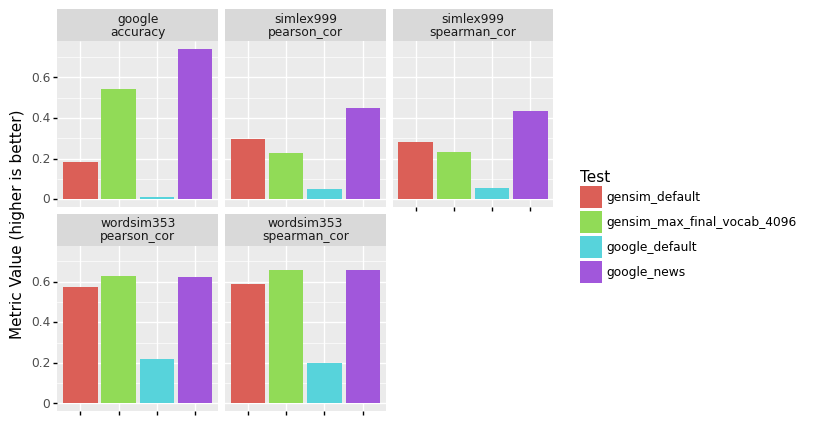

<ggplot: (8737553331277)>

In [7]:
(
    ggplot(benchmark_df, aes(x='short_name',y='value', fill='short_name'))
    + geom_bar(stat='identity')
    + facet_wrap(['test','metric'])
    + labs(fill="Test",x="",y="Metric Value (higher is better)")
    + theme(axis_text_x=element_blank())
)

In [8]:
similarities = []
for dirname in metrics.keys():
    for file in metrics[dirname]:
        file_shortname = "_".join(file.split('_')[:-1])
        similarities.append(metrics[dirname][file]['similarities'].assign(file=file_shortname))

In [9]:
(
    pd.concat(similarities)
    .reset_index()
    .rename(columns={'level_0':'test','level_1':'rank'})
    .query('rank <= 3')
    .drop('cosine_dist',axis=1)
    .pivot(index=['file','rank'],columns='test')
)

word                      \
test                             boat_similarity december_similarity   
file                        rank                                       
gensim_default              0              boats            november   
                            1             vessel            february   
                            2               ship               march   
                            3            steamer             january   
gensim_max_final_vocab_4096 0             vessel            november   
                            1              boats            february   
                            2               crew               march   
                            3              crews             january   
google_default              0           dialogue            november   
                            1             artist                july   
                            2         revolution               march   
                            3              1950s            february   
google_news                 0              boats           september   
                            1           sailboat               april   
                            2          motorboat             october   
                            3       fishing_boat            february   

                                                                      
test                             french_similarity street_similarity  
file                        rank                                      
gensim_default              0                dutch            avenue  
                            1              italian         boulevard  
                            2               german        piccadilly  
                            3              spanish              lane  
gensim_max_final_vocab_4096 0              italian            avenue  
                            1               german           streets  
                            2              spanish              road  
                            3                dutch              lane  
google_default              0               korean            bishop  
                            1                 tank                 h  
                            2            beautiful           antonio  
                            3              derived              earl  
google_news                 0               French           streets  
                            1               france          sidewalk  
                            2                dutch         boulevard  
                            3              italian             alley